In [1]:
%matplotlib inline

In [2]:
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm,colors
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
import community

# dataの読み込み

In [3]:
########################
# 課題2-1：異なるデータセットに対して実行
########################
G = nx.karate_club_graph()
pos = nx.spring_layout(G)
# True labels of the group each student (node) unded up in. Found via the original paper
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
########################
# 課題2-2：knnグラフを構築
########################

In [4]:
def draw_communities(G, membership, pos):
    """Draws the nodes to a plot with assigned colors for each individual cluster
    Parameters
    ----------
    G : networkx graph
    membership : list
        A list where the position is the student and the value at the position is the student club membership.
        E.g. `print(membership[8]) --> 1` means that student #8 is a member of club 1.
    pos : positioning as a networkx spring layout
        E.g. nx.spring_layout(G)
    """ 
    fig, ax = plt.subplots(figsize=(16,9))
    
    # Convert membership list to a dict where key=club, value=list of students in club
    club_dict = defaultdict(list)
    for student, club in enumerate(membership):
        club_dict[club].append(student)
    
    # Normalize number of clubs for choosing a color
    norm = colors.Normalize(vmin=0, vmax=len(club_dict.keys()))
    
    for club, members in club_dict.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=members,
                               node_color=cm.jet(norm(club)),
                               node_size=500,
                               alpha=0.8,
                               ax=ax)

    # Draw edges (social connections) and show final plot
    plt.title("Zachary's Karate Club")
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

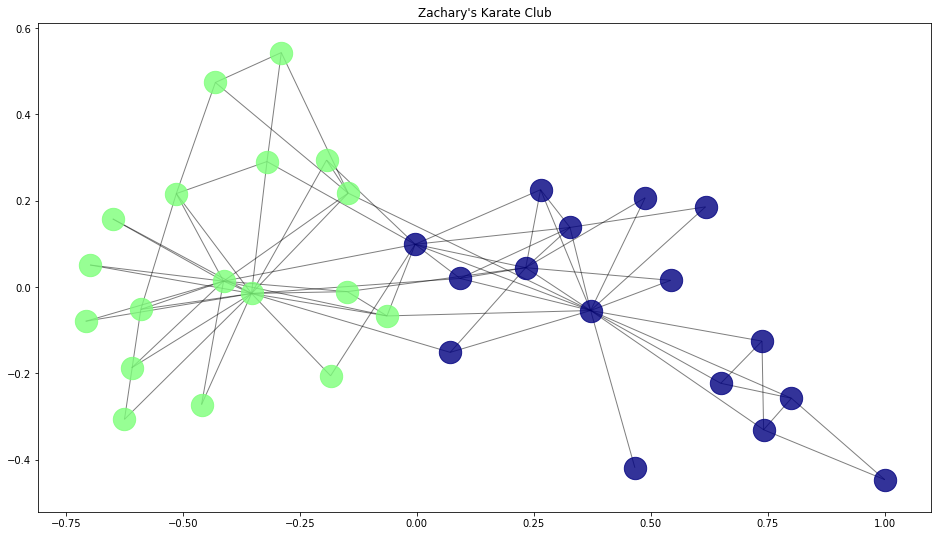

In [5]:
draw_communities(G, y_true, pos)

# 隣接行列の作成

In [6]:
def graph_to_edge_matrix(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/Incidence_matrix for a good explaination on edge matrices
   
    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    edge_mat = np.zeros((len(G), len(G)), dtype=int)

    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        for neighbor in G.neighbors(node):
            edge_mat[node][neighbor] = 1
        edge_mat[node][node] = 1

    return edge_mat

In [7]:
edge_mat = graph_to_edge_matrix(G)
edge_mat

array([[1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [8]:
results = []

## Modularity (louvain)

In [ ]:
##################
# 課題1-1：Modurarityの実装
# partition = 
##################

results.append(partition)
draw_communities(G, partition, pos)

## symNMF

In [ ]:
import sys
import numpy as np
import scipy.io as sio
import scipy.sparse as sp



def update_V(A,V):
   V_new = V*((A.dot(V)+A.transpose().dot(V))/(2*V.dot(V.transpose().dot(V)))) # this updating rule from partial differential
   return V_new

def removing_nan(mat):
   nan_list = np.argwhere(np.isnan(mat))
   for i in nan_list:
       mat[i[0],i[1]]=sys.float_info.epsilon
   return mat

def sumNMF(edge_mat, k=2):
    A = edge_mat
    node_size = A.shape[0]

    #initalize matrices
    V = np.random.random((node_size,k)) # V <- random
    max_iter=100



    #training step
    count = 0
    while 1:
       count += 1

       V = removing_nan(update_V(A,V))

       if count>=max_iter:
          break

    #predicting step
    pred=[]

    for i in range(len(V)):
       pred.append(np.argmax(V[:][i]))

    return pred

In [ ]:
##################
# 課題1-2：symNMFの実装
# pred_symNMF = 
##################

results.append(pred_symNMF)
draw_communities(G, pred, pos)

## SCAN

In [ ]:
from collections import deque
import numpy as np
from scipy.sparse import csr_matrix

def struct_similarity(vcols, wcols):
    """ Compute the similartiy normalized on geometric mean of vertices"""
    # count the similar rows for unioning edges
    count = [index for index in wcols if (index in vcols)]
    # geomean
    #need to account for vertex itself, add 2(1 for each vertex)
    ans = (len(count) +2) / (((vcols.size+1)*(wcols.size+1)) ** .5)
    return ans

def neighborhood(G, vertex_v, eps):
    """ Returns the neighbors, as well as all the connected vertices """
    N = deque()
    vcols = vertex_v.tocoo().col
    #check the similarity for each connected vertex
    for index in vcols:
        wcols = G[index,:].tocoo().col
        if struct_similarity(vcols, wcols)> eps:
            N.append(index)
    return N, vcols

def scan(G, eps =0.7, mu=2):
    """
    Vertex Structure = sum of row + itself(1)
    Structural Similarity is the geometric mean of the 2Vertex size of structure
    """
    
    c = 0
    v = G.shape[0]
    # All vertices are labeled as unclassified(-1)
    vertex_labels = -np.ones(v)
    # start with a neg core(every new core we incr by 1)
    cluster_id = -1
    for vertex in range(v):
        N ,vcols = neighborhood(G, G[vertex,:],eps)
        # must include vertex itself
        N.appendleft(vertex)
        if len(N) >= mu:
            #print "we have a cluster at: %d ,with length %d " % (vertex, len(N))
            # gen a new cluster id (0 indexed)
            cluster_id +=1
            while N:
                 y = N.pop()
                 R , ycols = neighborhood(G, G[y,:], eps)
                 # include itself
                 R.appendleft(y)
                 # (struct reachable) check core and if y is connected to vertex
                 if len(R) >= mu and y in vcols:
                     #print "we have a structure Reachable at: %d ,with length %d " % (y, len(R))
                     while R:
                         r = R.pop()
                         label = vertex_labels[r]
                         # if unclassified or non-member
                         if (label == -1) or (label==0): 
                             vertex_labels[r] =  cluster_id
                         # unclassified ??
                         if label == -1:
                             N.appendleft(r)
        else:
            vertex_labels[vertex] = 0
    
    #classify non-members
    for index in np.where(vertex_labels ==0)[0]:
        ncols= G[index,:].tocoo().col
        if len(ncols) >=2:
            ## mark as a hub
            vertex_labels[index] = -2 
            continue
            
        else:
            ## mark as outlier
            vertex_labels[index] = -3
            continue

    return vertex_labels


In [ ]:
##################
# 課題1-3：SCANの実装
# pred_scan = 
##################

results.append(pred_scan)
draw_communities(G, pred_scan, pos)

# 評価

In [ ]:
nmi_results = []
ars_results = []

# Append the results into lists
for y_pred in results:
    nmi_results.append(normalized_mutual_info_score(y_true, y_pred))
    ars_results.append(adjusted_rand_score(y_true, y_pred))

In [ ]:
nmi_results

In [ ]:
ars_results

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 5))

x = np.arange(len(y_true))

xlabels = ["Modularity", "symNMF", "SCAN"]

sns.barplot(x=xlabels,y=np.array(nmi_results), palette='Blues', ax=ax1)
sns.barplot(x=xlabels,y=np.array(ars_results), palette='Reds', ax=ax2)

ax1.set_ylabel('NMI Score')
ax2.set_ylabel('ARS Score')

# # Add the xlabels to the chart
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)

# Add the actual value on top of each bar
for i, v in enumerate(zip(nmi_results, ars_results)):
    ax1.text(i - 0.1, v[0] + 0.01, str(round(v[0], 2)))
    ax2.text(i - 0.1, v[1] + 0.01, str(round(v[1], 2)))

# Show the final plot
plt.savefig("score.png")
plt.show()